In [ ]:
# !export CUDA_VISIBLE_DEVICES=0,1

In [2]:
from fastai.vision.all import *
from fastcore.parallel import *
import timm


In [3]:
#!pip install kaggle
#!kaggle competitions download -c paddy-disease-classification
#!unzip paddy-disease-classification.jar -d ~/.fastai/data/
#mv paddy-disease-classification paddy

In [4]:
Path.BASE_PATH = path = Path.home()/'.fastai/data/paddy'; path.ls()

(#4) [Path('sample_submission.csv'),Path('train.csv'),Path('train_images'),Path('test_images')]

In [5]:
df = pd.read_csv(path/'train.csv'); df

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45
...,...,...,...,...
10402,107607.jpg,tungro,Zonal,55
10403,107811.jpg,tungro,Zonal,55
10404,108547.jpg,tungro,Zonal,55
10405,110245.jpg,tungro,Zonal,55


In [6]:
trn_path = path/'train_images'; trn_path

Path('train_images')

In [7]:
files = get_image_files(path/'train_images')

In [8]:
img = PILImage.create(files[0])

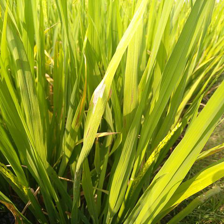

In [9]:
img.resize((224,224))

In [10]:
%time pd.DataFrame([str(PILImage.create(f).size) for f in files],columns =['dims']).value_counts()

CPU times: user 36.9 s, sys: 622 ms, total: 37.5 s
Wall time: 39.9 s


dims      
(480, 640)    10403
(640, 480)        4
dtype: int64

In [11]:
def f(i): return str(PILImage.create(i).size)

In [12]:
%time sizes = parallel(f, files, n_workers=4)

CPU times: user 4.27 s, sys: 616 ms, total: 4.89 s
Wall time: 15.9 s


In [13]:
%time sizes = parallel(f, files, n_workers=8)

CPU times: user 3.69 s, sys: 587 ms, total: 4.27 s
Wall time: 10.2 s


In [14]:
%time pd.DataFrame(list(sizes)).value_counts()

CPU times: user 9.32 ms, sys: 54 µs, total: 9.37 ms
Wall time: 7.41 ms


(480, 640)    10403
(640, 480)        4
dtype: int64

In [15]:
df.variety.value_counts()

ADT45             6992
KarnatakaPonni     988
Ponni              657
AtchayaPonni       461
Zonal              399
AndraPonni         377
Onthanel           351
IR20               114
RR                  36
Surya               32
Name: variety, dtype: int64

In [16]:
df.label.value_counts()

normal                      1764
blast                       1738
hispa                       1594
dead_heart                  1442
tungro                      1088
brown_spot                   965
downy_mildew                 620
bacterial_leaf_blight        479
bacterial_leaf_streak        380
bacterial_panicle_blight     337
Name: label, dtype: int64

In [17]:
img.size

(480, 640)

In [24]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42, item_tfms=Resize(480), batch_tfms=aug_transforms(size=224, min_scale=0.75))

[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]


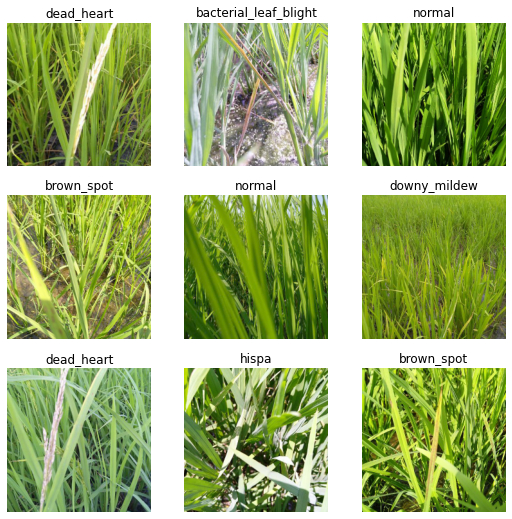

In [25]:
dls.show_batch();

# timm.list_models('*convnext*')

In [28]:
learn = vision_learner(dls, 'convnext_small_in22k', metrics=error_rate)

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_small_22k_224.pth" to /home/bilal/.cache/torch/hub/checkpoints/convnext_small_22k_224.pth


In [29]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.507778,0.738937,0.249399,00:35


epoch,train_loss,valid_loss,error_rate,time
0,0.836855,0.440321,0.142239,01:49
1,0.603297,0.329727,0.109082,01:49
2,0.455919,0.253788,0.084575,01:49
3,0.358668,0.205099,0.065834,01:49
4,0.284481,0.196951,0.062470,01:49


In [30]:
interp = ClassificationInterpretation.from_learner(learn)

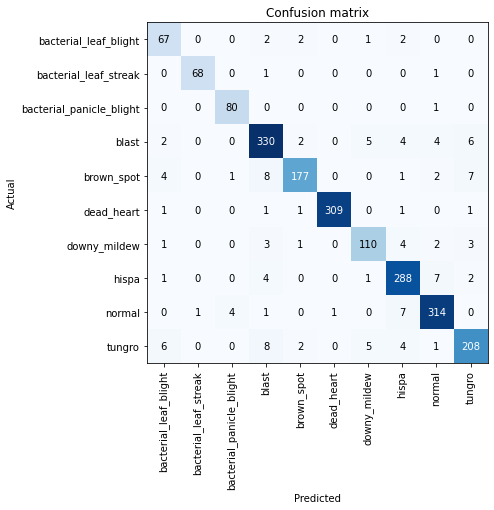

In [31]:
interp.plot_confusion_matrix(figsize=(7,7))

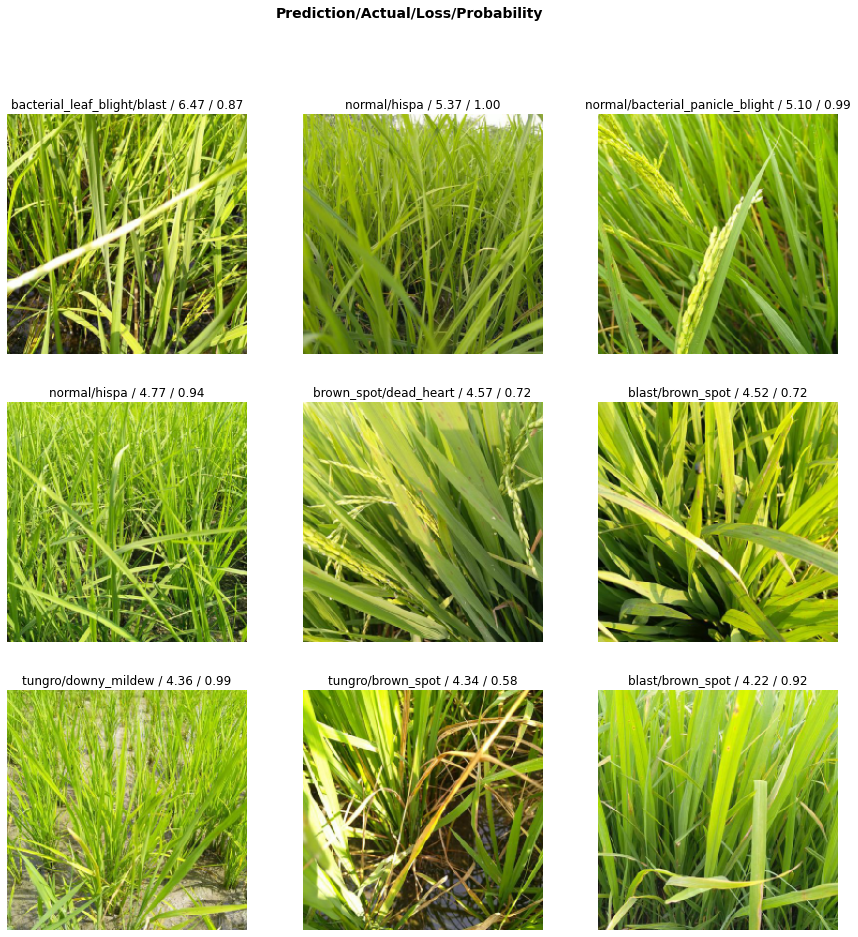

In [32]:
interp.plot_top_losses(9, figsize=(15,15))

In [ ]:
learn.export('paddle.pkl')

In [80]:
test_files = get_image_files(path/'test_images')

[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]


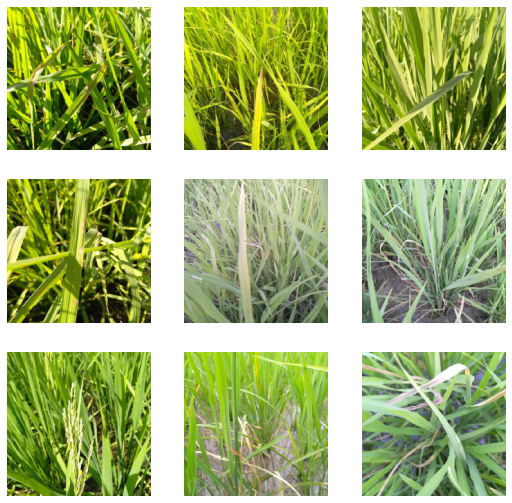

In [81]:
test_dl = dls.test_dl(test_files)
test_dl.show_batch()

In [42]:
my_submission_df = pd.read_csv(path/'sample_submission.csv'); my_submission_df

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


In [53]:
probs, _, idxs = learn.get_preds(dl=test_dl, with_decoded=True)

In [76]:
result=pd.DataFrame({"image_id": [i.name for i in learn.dl.items],  "idx": idxs.numpy()})
mapping = {k:v for k,v in enumerate(dls.vocab)}
result["label"]=result["idx"].map(mapping)
result.head(10)

,image_id,idx,label
0,201820.jpg,3,blast
1,202165.jpg,9,tungro
2,200827.jpg,8,normal
3,200237.jpg,4,brown_spot
4,200529.jpg,4,brown_spot
5,203307.jpg,3,blast
6,203037.jpg,2,bacterial_panicle_blight
7,202974.jpg,3,blast
8,200458.jpg,3,blast
9,200783.jpg,7,hispa


In [77]:
result.iloc[:,[0,2]].to_csv('submission_101.csv', index=False)

In [78]:
!head submission_101.csv

image_id,label
201820.jpg,blast
202165.jpg,tungro
200827.jpg,normal
200237.jpg,brown_spot
200529.jpg,brown_spot
203307.jpg,blast
203037.jpg,bacterial_panicle_blight
202974.jpg,blast
200458.jpg,blast


### Making kaggle submission

In [79]:
!kaggle competitions submit -f ~/mlworks/plant_disease_detection/submission_101.csv -m 'init convnext small 5 epochs' paddy-disease-classification

100%|██████████████████████████████████████| 70.1k/70.1k [00:01<00:00, 41.9kB/s]
Successfully submitted to Paddy Doctor: Paddy Disease Classification